In [1]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = 'E:\\CIFAR-10-images-master\\CIFAR-10-images-master\\train'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path,img))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 5000/5000 [00:00<00:00, 8864.28it/s]

50000


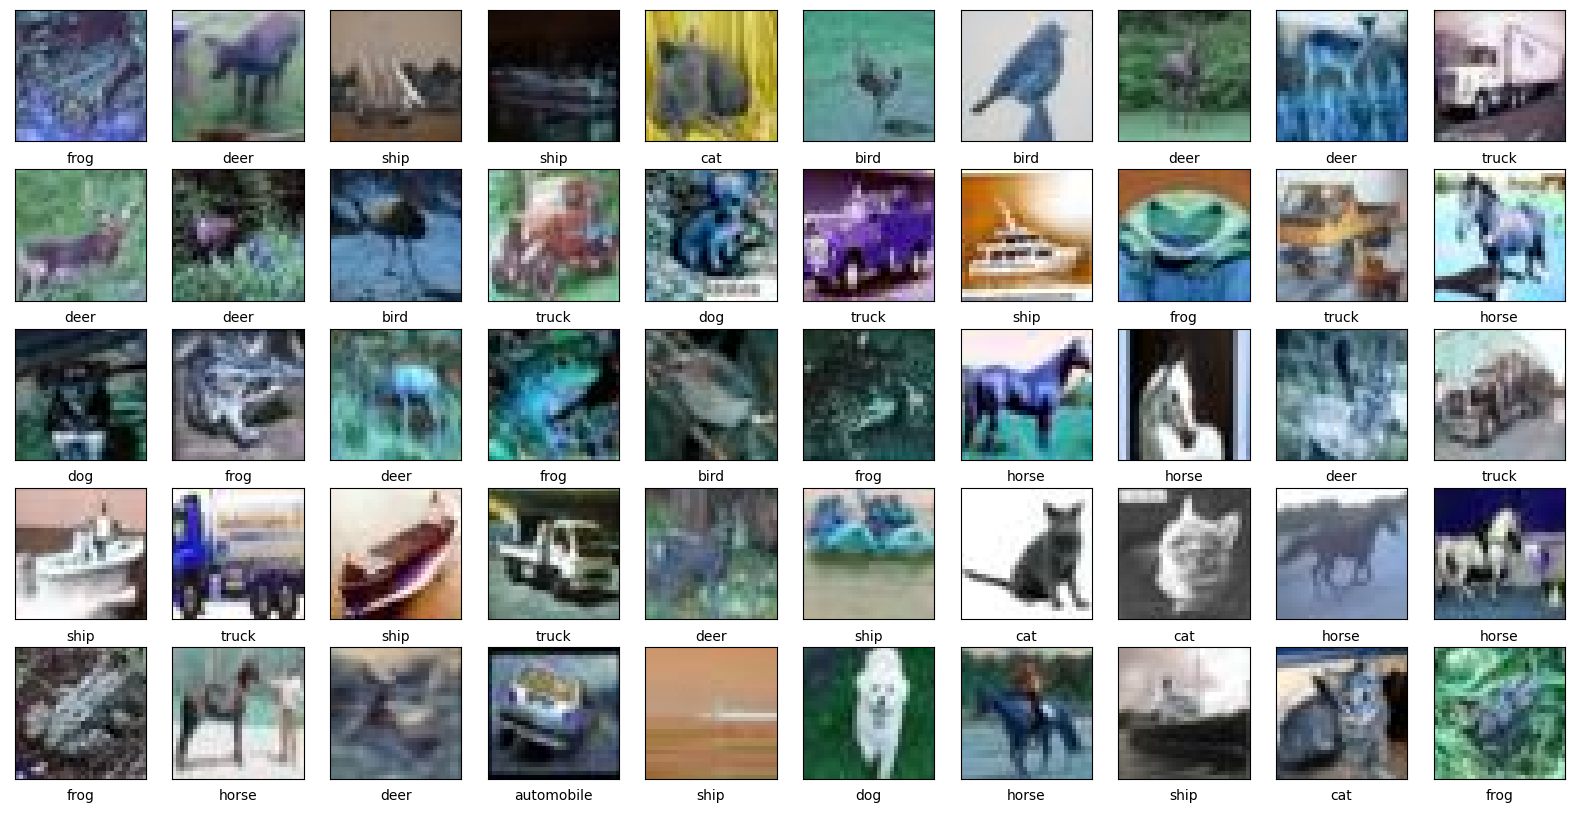

In [4]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20,10))

for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(TRAIN_DATA[i][0])
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

In [5]:
f0 = TRAIN_DATA[0:1000]
f1 = TRAIN_DATA[1000:2000]
f2 = TRAIN_DATA[2000:3000]
f3 = TRAIN_DATA[3000:4000]
f4 = TRAIN_DATA[4000:5000]

In [6]:
by_l1_dist = lambda x: x[2]["l1"]
by_l2_dist = lambda x: x[2]["l2"]

In [7]:
top_filter = 20

def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold): 
        temp_dist_list = []
        for train in train_fold: 
            l1_dist = np.sum(np.abs(valid[0] - train[0]))
            l2_dist = np.sqrt(np.sum((valid[0] - train[0]) ** 2))
            temp_dist_list.append({
                "valid_idx": valid[1],
                "train_idx": train[1],
                "distances": {"l1": l1_dist, "l2": l2_dist}
            })
        temp_dist_list.sort(key=lambda x: x["distances"]["l1"])
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=lambda x: x["distances"]["l2"])
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]

In [8]:
k_range = 20

def cal_accuracy(dist_result, dist_term):
    k_accuracies = []  
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = list(filter(lambda x: x[0] == x[1], nn))
            same_class_len = len(same_class)
            if k % 2 != 0:
                if ((k-1) // 2) < same_class_len:
                    img_accuracy += 1
            else:
                diff_class = list(filter(lambda x: x[0] != x[1], nn))
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class):
                    same_class_dist = sum([n["distances"][dist_term] for n in same_class])
                    diff_class_dist = sum([n["distances"][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1
        k_accuracies.append(img_accuracy / len(dist_result))
    return k_accuracies

In [9]:
dist_by_fold = []
folds = [f0, f1, f2, f3, f4]
for i, valid_fold in enumerate(folds):
    train_folds = [fold for j, fold in enumerate(folds) if j != i]
    train_fold = [item for sublist in train_folds for item in sublist]
    dist_by_fold.append(distance_calc(train_fold, valid_fold))

100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]


In [17]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

KeyError: 0

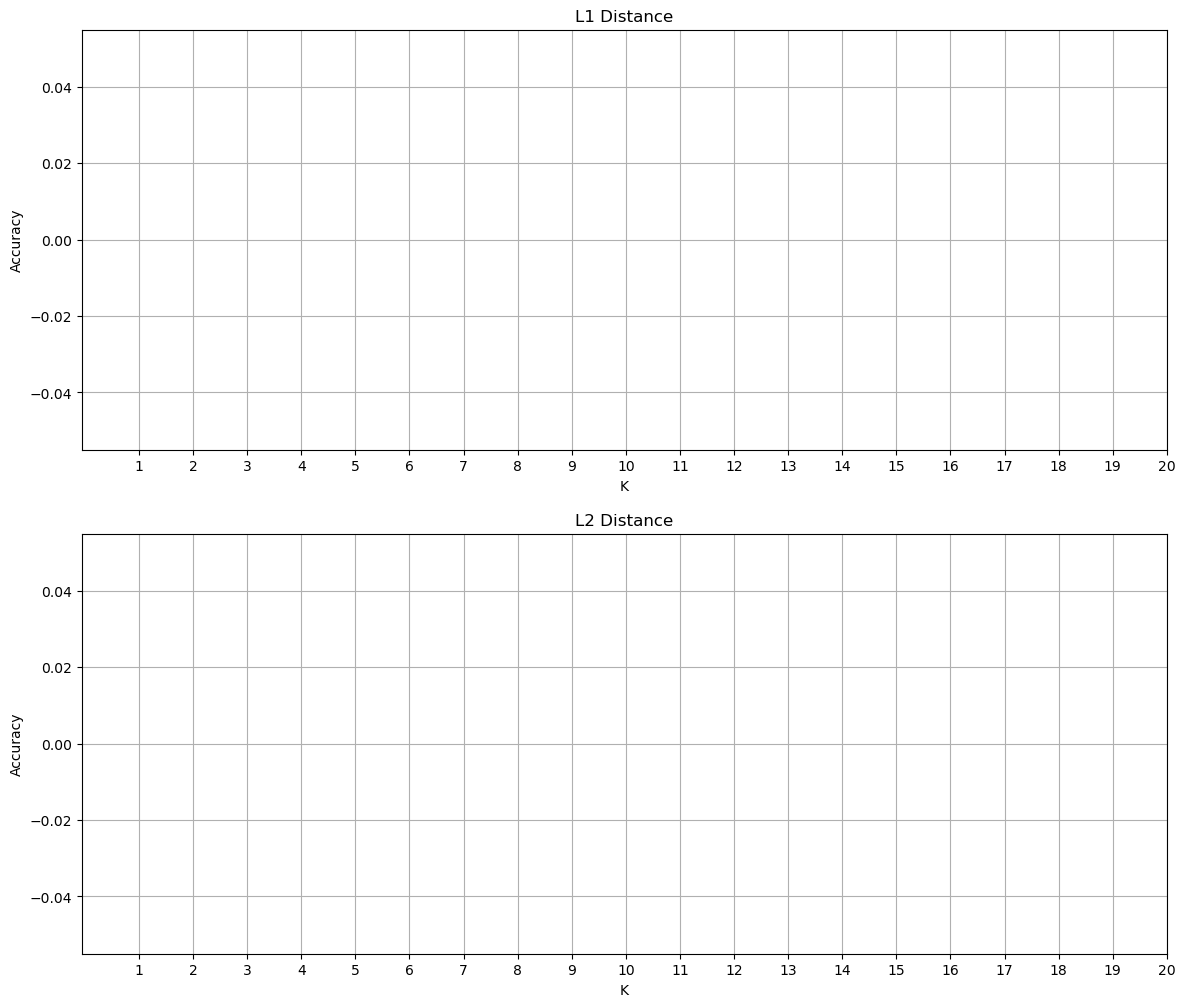

In [16]:
x_list = list(range(1, k_range+1))

fig, axs = plt.subplots(nrows=2, figsize=(14, 12))

for i, ax in enumerate(axs):
    y_list = [fold[i] for fold in accuracies]
    for fold in accuracies:
        ax.scatter(x_list, fold[i])
    trend = [np.mean([fold[i][j] for fold in accuracies]) for j in range(k_range)]
    ax.errorbar(x_list, trend, fmt='-o')
    ax.set_title(f'L{i+1} Distance')
    ax.set_xticks(x_list)
    ax.grid(True)
    ax.set_xlabel('K')
    ax.set_ylabel('Accuracy')

plt.show()